(1001, 6) (6, 1001)
(1001, 6) (6, 1001)


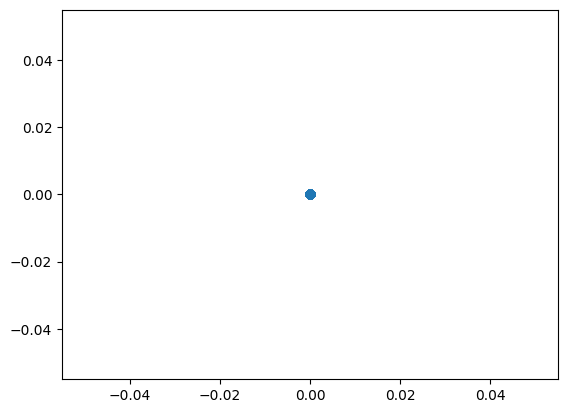

In [1]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as lin
import sys
sys.path.append('../src')
import quadrotor as qd
import math

def get_linearization(z, u):
    z = z.reshape(-1)
    dt = qd.DELTA_T
    m = qd.MASS
    theta = z[4].item()
    omega = z[5].item()
    u0 = u[0].item()
    u1 = u[1].item()
    r = qd.LENGTH
    I = qd.INERTIA
    A = np.array([[1., dt, 0., 0., 0., 0.],
                    [0., 1., 0., 0., dt * (math.cos(theta) * (-u0 - u1)) / m, 0.],
                    [0., 0., 1., dt, 0., 0.],
                    [0., 0., 0., 1., -dt * (math.sin(theta) * (-u0 - u1)) / m, 0.],
                    [0., 0., 0., 0., 1., dt],
                    [0., 0., 0., 0., 0., 1.]])

    B = np.array([[0., 0.],
                    [-dt * (math.sin(theta) / m), -dt * (math.sin(theta) / m)],
                    [0., 0.],
                    [dt * (math.cos(theta) / m), dt * (math.cos(theta) / m)],
                    [0., 0.],
                    [(dt * r) / I, -(dt * r) / I]])

    return A, B

horizon_length = 1000
N = 1000
u_ = qd.MASS*qd.GRAVITY/2
z0 = np.array([1,0,0,0,0,0]).reshape([6,])
u0 = u_ * np.ones([2,1])
o = (2*math.pi/10)
r = 1
T = 10


x_desired = [0 for i in range(0,N+1)]
y_desired = [0 for i in range(0,N+1)]
vx_desired = [0 for i in range(0,N+1)]
vy_desired = [0 for i in range(0,N+1)]
theta_desried = [0 for i in range(0,N+1)]
omega_desried = [0 for i in range(0,N+1)]



state_desired = np.array([x_desired,vx_desired,y_desired,vy_desired,theta_desried,omega_desried])
ref_traj = state_desired.T
print(ref_traj.shape,state_desired.shape)



z0 = np.zeros_like(state_desired[:,0])
u_init = [(qd.MASS * qd.GRAVITY / 2) * np.ones([2]) for _ in range(horizon_length)]
print(ref_traj.shape,state_desired.shape)

plt.figure()
plt.scatter(x_desired,y_desired)

plt.show()


In [2]:
A, B = get_linearization(np.zeros(6),u0) 
A

array([[ 1.    ,  0.01  ,  0.    ,  0.    ,  0.    ,  0.    ],
       [ 0.    ,  1.    ,  0.    ,  0.    , -0.0981,  0.    ],
       [ 0.    ,  0.    ,  1.    ,  0.01  ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  1.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  1.    ,  0.01  ],
       [ 0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  1.    ]])

In [3]:
Q = np.diag([1, 1, 1, 1, 1, 1])
R = np.diag([0.01, 0.01])
P_last = Q


while True:
    Pnew = Q + A.transpose().dot(P_last).dot(A) - A.transpose().dot(P_last).dot(B).dot(np.linalg.inv(B.transpose().dot(P_last).dot(B)+R)).dot(B.transpose().dot(P_last).dot(A))
    err = Pnew.reshape(-1) - P_last.reshape(-1)
    err = np.sum(err @ err.T)
    if err < 0.00011:
        break
    else:
        P_last = Pnew

K = -np.identity(2).dot(np.linalg.inv(B.transpose().dot(P_last).dot(B)+R)).dot(B.transpose().dot(P_last).dot(A))

In [4]:
%%time

def lqr_controller(state,i):
    ut = K.dot(state) + u_init[0]
    return ut.T
t, state, u = qd.simulate(z0,lqr_controller, horizon_length, disturbance = True)



CPU times: user 28.1 ms, sys: 3.84 ms, total: 31.9 ms
Wall time: 29.5 ms


RuntimeError: Requested MovieWriter (ffmpeg) not available

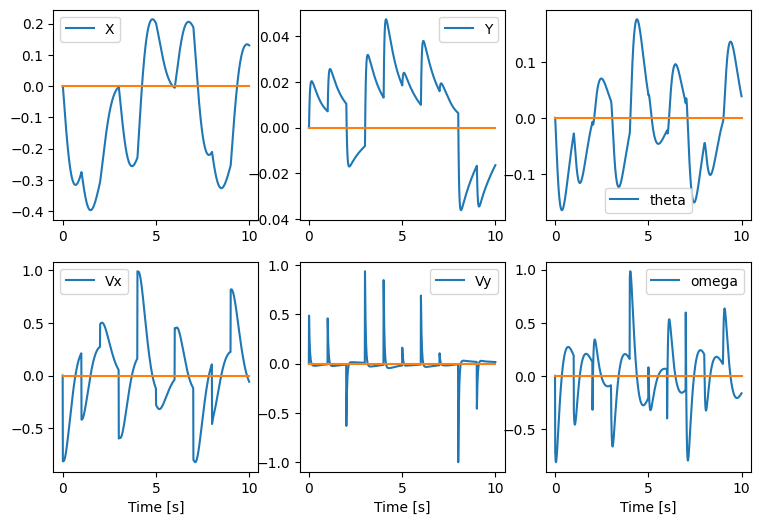

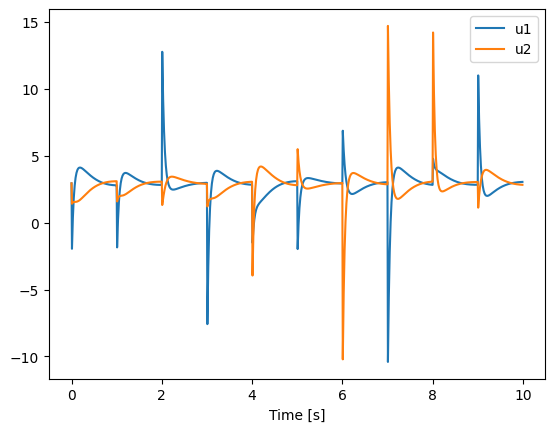

In [5]:

# we can plot the results
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.plot(t, state_desired[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.plot(t, state_desired[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.plot(t, state_desired[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.plot(t, state_desired[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.plot(t, state_desired[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.plot(t, state_desired[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')
qd.animate_robot(state,u)